In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env
from stable_baselines3.common.env_checker import check_env

check_env(X2Env())

In [4]:
from stable_baselines3 import PPO
from uuid import uuid4

env = X2Env()

model = PPO("MlpPolicy", env, verbose=1, seed=0, learning_rate=0.0001)

model.learn(total_timesteps=100_000)

path = f"models/{uuid4()}.model"
print(path)

model.save(path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.1     |
|    ep_rew_mean     | 25.9     |
| time/              |          |
|    fps             | 531      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.7         |
|    ep_rew_mean          | 28           |
| time/                   |              |
|    fps                  | 384          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037225483 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    e

In [58]:
import numpy as np

from typing import List


def make_env(seed: int) -> X2Env:
    env = X2Env()
    env.reset(seed=seed)
    return env


envs = [make_env(s) for s in range(10_000)]


def step_env_batch(model: PPO, batch: List[int]):
    all_obs = np.vstack([envs[i].get_observation() for i in batch])

    actions, _ = model.predict(all_obs, deterministic=True)

    for action, i in zip(actions, batch):
        envs[i].step(action)


def step_envs(model: PPO, batch_size: int = 128) -> int:
    games_still_going = False

    batch = []

    for i, env in enumerate(envs):
        if not env.is_game_over():
            batch.append(i)
            games_still_going += 1

        if (len(batch) > 0) and (len(batch) % batch_size == 0):
            step_env_batch(model, batch)
            batch = []

    # last batch to cleanup
    if len(batch) > 0:
        step_env_batch(model, batch)

    return games_still_going


iter = 0
while (games := step_envs(model)) > 0:
    if iter % 10 == 0:
        print(f"games still going after {iter} plays each: {games}")
    iter += 1

rewards = [e.get_total_reward() for e in envs]
np.mean(rewards), np.std(rewards)

games still going after 0 plays each: 10000
games still going after 10 plays each: 10000
games still going after 20 plays each: 9998
games still going after 30 plays each: 9652
games still going after 40 plays each: 6728
games still going after 50 plays each: 3074
games still going after 60 plays each: 1035
games still going after 70 plays each: 298
games still going after 80 plays each: 74
games still going after 90 plays each: 20
games still going after 100 plays each: 3


(39.0437, 11.896024138761655)

array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

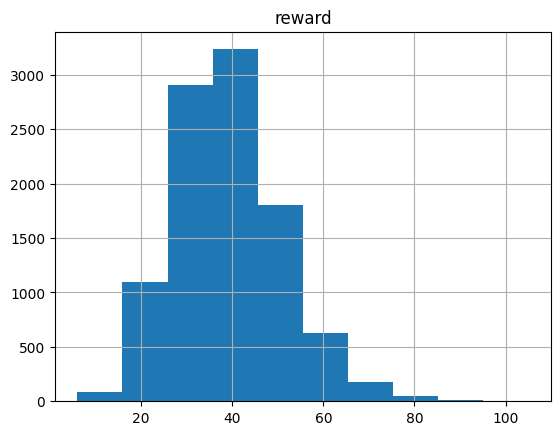

In [59]:
import pandas as pd

df = pd.DataFrame(rewards, columns=["reward"])
df.hist()

In [60]:
seed = int(np.argmax(rewards))
print(seed)

env = X2Env()
state, _ = env.reset(seed=seed)

6134


In [82]:
from x2 import print_grid

s = env.get_state()

print_grid(s.grid)

action, _ = model.predict(state, deterministic=True)

print(f"next: {s.next_play} action: {action}")

next_state, reward, done, _, _ = env.step(action)

print_grid(s.grid)

0002 0003 0008 0004 ----
---- 0001 0006 0003 ----
---- 0003 0002 0005 ----
---- 0002 0005 0003 ----
---- 0001 ---- 0005 ----
next: 2 action: 0
0004 0001 0008 0006 ----
---- 0004 0007 ---- ----
---- 0001 ---- ---- ----
---- ---- ---- ---- ----
---- ---- ---- ---- ----
